In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LogLocator, LogFormatter
import scipy.io as scio

axis_type = 1
num_samples = 5
T2_dim = 100
D_dim = 100
T2_lable_dim = 100
D_label_dim = 100
num_DT = 5
if axis_type == 1:
    max_D = 10**(0)
    max_T2 = 10**(0)
    floor_D = 10**(-1)
    floor_T2 = 10**(-1)
elif axis_type == 0:
    max_D = 10
    max_T2 = 1
    floor_D = 0
    floor_T2 = 0
min_sep_D = 0.1
min_sep_T2 = 0.1
# floor_sig_D = 0.02
# floor_sig_T2 = 0.02
# max_sig_D = 0.04
# max_sig_T2 = 0.04
sig_D = 0.02
sig_T2 = 0.02
floor_amp = 0.3
max_b = 5
max_t = 5

def gaussian_blind_noise(S, dB):
    """
    Add Gaussian noise to the input signal. The std of the gaussian noise is uniformly chosen between 0 and 1/sqrt(snr).
    """
    snr = np.exp(np.log(10) * float(dB) / 10)
    num_samples, signal_dim, num_fre = np.shape(S)
    noise_S = np.zeros([num_samples, signal_dim, num_fre])
    # sigma_max = np.sqrt(1. / snr)
    # sigmas = sigma_max * np.random.rand(num_samples)
    sigma = np.sqrt(1. / snr)

    for i in np.arange(num_samples):
        noise = np.random.randn(signal_dim, num_fre) * S[i, :, :]
        # mult = sigmas[i] * np.linalg.norm(s, 2) / (np.linalg.norm(noise, 2))
        mult = sigma * np.linalg.norm(S[i, :, :], ord='fro') / (np.linalg.norm(noise, ord='fro'))
        noise = noise * mult
        
        noise_S[i, :, :] = S[i, :, :] + noise
    return noise_S

# to generate gaussian distribution
def Gaussian_distribution(max_D, floor_D, avg, num, sig):
    avg = avg.T
    xgrid = np.linspace(floor_D, max_D, num)
    sqrt_2pi=np.power(2*np.pi,0.5)
    coef=1/(sqrt_2pi*sig)
    powercoef=-1/(2*np.power(sig,2))
    mypow=powercoef*(np.power((xgrid-avg),2))
    result = coef*(np.exp(mypow))
    result[np.isnan(result)] = 0
    return result/np.max(result)

def Gaussian_distribution_log(max_D, floor_D, avg, num, sig):
    xgrid = np.logspace(np.log10(floor_D), np.log10(max_D), num)
    result = np.exp(-(np.log10(xgrid) - avg.T)**2 / (2 * sig**2)) / (xgrid * sig * np.sqrt(2 * np.pi))
    result[np.isnan(result)] = 0
    return result/np.max(result, axis=-1)[:, np.newaxis]

S = np.zeros([num_samples+2, D_dim, T2_dim])
label = np.zeros([num_samples+2, D_label_dim, T2_lable_dim])
b = np.linspace(max_b / D_dim, max_b, D_dim)[:, np.newaxis]
t = np.linspace(max_t / T2_dim, max_t, T2_dim)[:, np.newaxis]
# b = scio.loadmat('Dataset/T2-T2_mt50ms.mat')['t2values']
# t = scio.loadmat('Dataset/T2-T2_mt50ms.mat')['t2values']
if axis_type == 0:
    tt = np.linspace(max_T2 / T2_lable_dim, max_T2, T2_lable_dim)[np.newaxis, :]
    dd = np.linspace(max_D / D_label_dim, max_D, D_label_dim)[np.newaxis, :]
elif axis_type == 1:
    tt = np.logspace(np.log10(floor_T2), np.log10(max_T2), T2_lable_dim)[np.newaxis, :]
    dd = np.logspace(np.log10(floor_D), np.log10(max_D), D_label_dim)[np.newaxis, :]
KD = np.exp(-np.dot(b, 1 / dd))
# KD = np.exp(-np.dot(b, dd))
KT = np.exp(-np.dot(t, 1 / tt))
nDT = np.random.randint(1, num_DT + 1, num_samples)
# nDT[0] = 4

for i in np.arange(1, num_samples+1):
    D = np.ones([1, num_DT]).astype(float)
    T2 = np.zeros([1, num_DT]).astype(float)
    signal = np.zeros([D_dim, T2_dim]).astype(float)
    label1 = np.zeros([D_label_dim, T2_lable_dim]).astype(float)
    label2 = np.zeros([D_label_dim, T2_lable_dim]).astype(float)
    labelD = np.zeros([1, D_label_dim]).astype(float)
    labelT2 = np.zeros([1, T2_lable_dim]).astype(float)

    if axis_type == 1:
        for j in np.arange(i):
            D_value = np.random.uniform(low=np.log10(floor_D), high=np.log10(max_D))

            condition = True
            while condition:
                D_value = np.random.uniform(low=np.log10(floor_D), high=np.log10(max_D))
                condition = np.min(np.abs(D - D_value)) < min_sep_D or D_value < np.log10(floor_D)
            D[0, j] = D_value

            T2_value = np.random.uniform(low=np.log10(floor_T2), high=np.log10(max_T2))
            condition = True
            while condition:
                T2_value = np.random.uniform(low=np.log10(floor_T2), high=np.log10(max_T2))
                condition = np.min(np.abs(T2 - T2_value)) < min_sep_T2 or T2_value < np.log10(floor_T2)
            T2[0, j] = T2_value

        label_D = Gaussian_distribution_log(max_D, floor_D, D, D_label_dim, sig=sig_D)
        label_T2 = Gaussian_distribution_log(max_T2, floor_T2, T2, T2_lable_dim, sig=sig_T2)

    elif axis_type == 0:
        for j in np.arange(i):
            D_value = np.random.uniform(low=floor_D, high=max_D)
            condition = True
            while condition:
                D_value = np.random.uniform(low=floor_D, high=max_D)
                condition = np.min(np.abs(D - D_value)) < min_sep_D or D_value < floor_D
            D[0, j] = D_value

            T2_value = np.random.uniform(low=floor_T2, high=max_T2)
            condition = True
            while condition:
                T2_value = np.random.uniform(low=floor_T2, high=max_T2)
                condition = np.min(np.abs(T2 - T2_value)) < min_sep_T2 or T2_value < floor_T2
            T2[0, j] = T2_value

        label_D = Gaussian_distribution(max_D, floor_D, D, D_label_dim, sig=sig_D)
        label_T2 = Gaussian_distribution(max_T2, floor_T2, T2, T2_lable_dim, sig=sig_T2)

    for j in np.arange(i):
        # amp = np.abs(np.random.randn()) + floor_amp
        amp = max(np.abs(np.random.rand()), floor_amp)
        # signal = signal + amp * np.dot(np.exp(-b * R1[0, j]), np.exp(-t * R[0, j]).T)
        label1 = label1 + amp * np.dot(label_D[j, :][:, np.newaxis], label_T2[j, :][np.newaxis, :])
        # label2 = label2 + np.dot(label_D[j, :][:, np.newaxis], label_T2[j, :][np.newaxis, :])
        # label1 = label1 + np.dot(label_D[j, :][:, np.newaxis], label_T2[j, :][np.newaxis, :])
        # labelD = labelD + label_D[j, :][np.newaxis, :]
        # labelT2 = labelT2 + label_T2[j, :][np.newaxis, :]
        labelD = labelD + amp * label_D[j, :][np.newaxis, :]
        labelT2 = labelT2 + amp * label_T2[j, :][np.newaxis, :]
    signal = np.matmul(np.matmul(KD, label1), KT.T)
    S[i-1] = signal / np.max(signal)
    label[i-1] = label1 / np.max(label1)
    # label[i-1] = label2 / np.max(label2)
    labeltest = np.dot(labelD.T, labelT2)
    sample = 0


In [ ]:
pad_labelD = labelD.T.repeat(100, axis=1)
pad_labelT2 = labelT2.repeat(100, axis=0)
result_label = pad_labelD * pad_labelT2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

S = np.load('Dataset/valid_input.npy')
label = np.load('Dataset/valid_label.npy')

sample = np.random.randint(1000)
print('sample = ', sample)


In [ ]:
import torch
from scipy.interpolate import interp2d

def generate_decay(b, t, max_D, max_T, out, DEVICE):
    b = b.to(DEVICE)
    t = t.to(DEVICE)
    bsz, input_dim = b.shape

    range_D = np.linspace(max_D / input_dim, max_D, input_dim)
    range_T = np.linspace(max_T / input_dim, max_T, input_dim)
    range_D = torch.from_numpy(range_D).float().to(DEVICE).repeat(bsz, 1)
    range_T = torch.from_numpy(range_T).float().to(DEVICE).repeat(bsz, 1)

    KD = torch.exp(-torch.matmul(b.unsqueeze(2), 1 / range_D.unsqueeze(1)))
    KT = torch.exp(-torch.matmul(t.unsqueeze(2), 1 / range_T.unsqueeze(1)))

    X1 = torch.matmul(KD, out)
    X = torch.matmul(X1, KT.permute(0, 2, 1))
    X = X / X[:, 0, 0].reshape(bsz, 1, 1)
    
    return X

decay_data = SN[2, :, :]
label_data = label[2, :, :]
label_data = label_data / np.max(label_data)
b = b.squeeze()
t = t.squeeze()

max_row = np.max(decay_data, axis=1)
max_col = np.max(decay_data, axis=0)
row_position = np.where(max_row > 0.05)
col_position = np.where(max_col > 0.05)
new_b = b[row_position]
new_t = t[col_position]
# new_decay_data = decay_data[row_position, col_position]

new_t = np.linspace(np.min(new_t), np.max(new_t), 100)
new_b = np.linspace(np.min(new_b), np.max(new_b), 100)
range_D = np.linspace(max_D / D_label_dim, max_D, D_label_dim)
range_T = np.linspace(max_T2 / T2_lable_dim, max_T2, T2_lable_dim)

new_b = torch.from_numpy(new_b.copy()).float()
new_t = torch.from_numpy(new_t.copy()).float()
range_D = torch.from_numpy(range_D.copy()).float()
range_T = torch.from_numpy(range_T.copy()).float()

KD = torch.exp(-torch.matmul(new_b.unsqueeze(1), 1 / range_D.unsqueeze(0)))
KT = torch.exp(-torch.matmul(new_t.unsqueeze(1), 1 / range_T.unsqueeze(0)))

label_data = torch.from_numpy(label_data.copy()).float()
# decay_data = torch.matmul(torch.matmul(KD, label_data), KT.permute(1, 0))
# decay_data = decay_data / decay_data[0, 0]
interp_func = interp2d(t, b, decay_data, kind='cubic')
decay_data = interp_func(new_t, new_b)
decay_data = decay_data / decay_data[0, 0]
decay_data = torch.from_numpy(decay_data.copy()).float()

b1 = new_b
t1 = new_t

b1 = b1.unsqueeze(0)
t1 = t1.unsqueeze(0)
decay_data = decay_data.unsqueeze(0)
label_data = label_data.unsqueeze(0)

new_decay = generate_decay(b1, t1, 1, 1, label_data, b1.device)

print(decay_data - new_decay)

figure = plt.figure(1)
axes = Axes3D(figure)
x = t1.cpu().detach().numpy()
y = b1.cpu().detach().numpy()
X,Y = np.meshgrid(x, y)
Z = decay_data.cpu().detach().numpy().squeeze()
axes.plot_surface(X,Y,Z,cmap='rainbow')
# axes.view_init(elev=30,azim=45)

plt.figure(2, figsize=[15, 5])
plt.subplot(1, 2, 1)
for i in np.arange(D_dim):
    plt.plot(x.squeeze(), Z[i, :])
plt.subplot(1, 2, 2)
for j in np.arange(D_dim):
    plt.plot(y.squeeze(), Z[:, j])

plt.figure(2, figsize=[15, 5])
plt.subplot(1, 2, 1)
for i in np.arange(D_dim):
    plt.plot(x.squeeze(), Z[i, :])
plt.subplot(1, 2, 2)
for j in np.arange(D_dim):
    plt.plot(y.squeeze(), Z[:, j])


/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys
/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and Tr

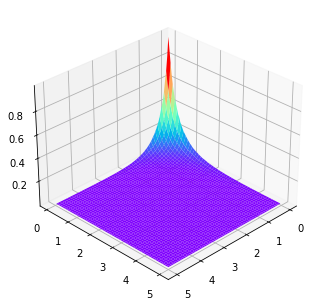

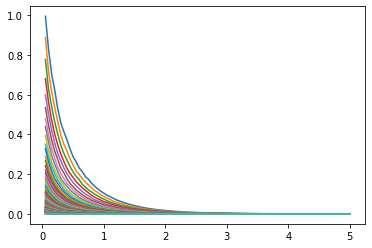

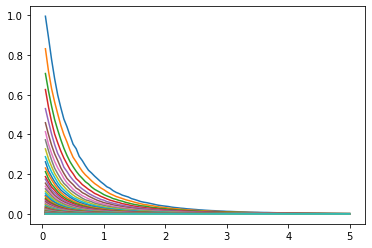

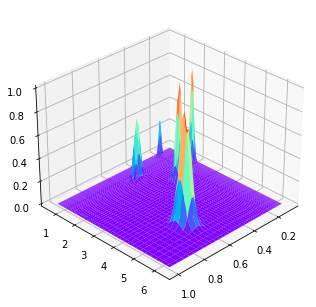

<Figure size 360x360 with 0 Axes>

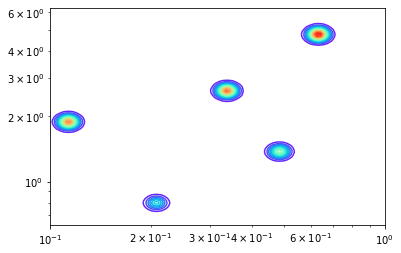

In [2]:
sample = 4
dB = 40
SN = gaussian_blind_noise(S, dB)
# SN = S

figure = plt.figure(1)
axes = Axes3D(figure)

# y = np.linspace(max_b / D_dim, max_b, D_dim)
# x = np.linspace(max_t / T2_dim, max_t, D_dim)
y = b
x = t

X,Y = np.meshgrid(x, y)
Z = SN[sample]
axes.plot_surface(X,Y,Z,cmap='rainbow')
axes.view_init(elev=30,azim=45)

plt.figure(2)
for i in np.arange(D_dim):
    # plt.plot(np.linspace(0.01, 1, 100), SN[sample, i, :] / np.max(SN[sample, i, :]))
    plt.plot(x, SN[sample, i, :])

plt.figure(3)
for j in np.arange(D_dim):
    # plt.plot(np.linspace(0.01, 1, 100), SN[sample, :, j]/np.max(SN[sample, :, j]))
    plt.plot(y, SN[sample, :, j])

figure = plt.figure(4)
ax = Axes3D(figure)

if axis_type == 1:
    X = np.logspace(np.log10(floor_T2), np.log10(max_T2), T2_lable_dim)[np.newaxis, :]
    Y = np.logspace(np.log10(floor_D), np.log10(max_D), D_label_dim)[np.newaxis, :]
elif axis_type == 0:
    X = np.linspace(floor_T2, max_T2, T2_lable_dim)[np.newaxis, :]
    Y = np.linspace(floor_D, max_D, D_label_dim)[np.newaxis, :]
X,Y = np.meshgrid(X, Y)
Z = label[sample]

ax.plot_surface(X,Y,Z,cmap='rainbow')
ax.view_init(elev=30,azim=45)
plt.show()

plt.figure(5, figsize=(5,5))
fig, ax = plt.subplots()
ax.contour(X, Y, Z, 20, cmap='rainbow')
if axis_type == 1:
    # 将x轴和y轴改为对数坐标轴
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.show()

In [3]:
test_DT = np.load('./Dataset/test_DT.npy')
test_TT2 = np.load('./Dataset/test_TT2.npy')
SN[5] = test_DT
SN[6] = test_TT2

# for i in range(len(SN)):
#     decay_data = SN[i, :, :]
#     b = b.squeeze()
#     t = t.squeeze()

#     max_row = np.max(decay_data, axis=1)
#     max_col = np.max(decay_data, axis=0)
#     row_position = np.where(max_row > 0.05)
#     col_position = np.where(max_col > 0.05)
#     new_b = b[row_position]
#     new_t = t[col_position]
#     # new_decay_data = decay_data[row_position, col_position]

#     interp_func = interp2d(t, b, decay_data, kind='cubic')
#     new_t = np.linspace(np.min(new_t), np.max(new_t), 100)
#     new_b = np.linspace(np.min(new_b), np.max(new_b), 100)
#     decay_data = interp_func(new_t, new_b)
#     SN[i, :, :] = decay_data

np.save('./Dataset/test_input.npy', SN)
np.save('./Dataset/test_label.npy', label)

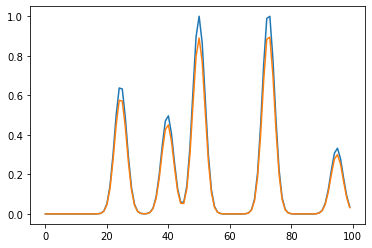

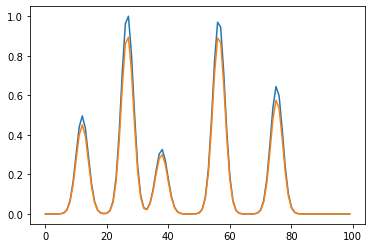

In [11]:
plt.figure(1)
# plt.plot(np.sum(label[sample], axis=1).T)
plt.plot(np.sum(label[sample], axis=1).T / np.max(np.sum(label[sample], axis=1)))
# plt.figure(2)
plt.plot(labelD.T)
plt.figure(2)
# plt.plot(np.sum(label[sample], axis=0).T)
plt.plot(np.sum(label[sample], axis=0).T / np.max(np.sum(label[sample], axis=0)))
# plt.figure(2)
plt.plot(labelT2.T)

In [ ]:
import torch

torch_label = torch.from_numpy(label).float()
torch_labelD = torch.from_numpy(labelD).float()
torch_labelT2 = torch.from_numpy(labelT2).float()

rc_labelD = torch.sum(torch_label, dim=2).numpy()
rc_labelT2 = torch.sum(torch_label, dim=1).numpy()

plt.figure(1)
plt.plot(rc_labelD.T / np.sum(rc_labelD))
plt.plot(labelD.T / np.sum(labelD))
plt.figure(2)
plt.plot(rc_labelT2.T / np.sum(rc_labelT2))
plt.plot(labelT2.T / np.sum(labelT2))

In [ ]:
plt.figure(1)
plt.plot(label_D.T)
plt.figure(2)
plt.plot(label_T2.T)

In [ ]:
plt.figure(1)
for i in np.arange(100):
    plt.plot(b, S[0, i, :] / np.max(S[0, i, :]))

plt.figure(2)
for j in np.arange(100):
    plt.plot(t, S[0, :, j]/np.max(S[0, :, j]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成x轴数据（在logspace上）
x = np.logspace(-3, 3, num=1000)

# 计算理想高斯分布的y轴数据
mu = 0
sigma = 1
y = np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))

# 绘制图像
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xscale('log')

# 添加轴标签和标题
ax.set_xlabel('x')
ax.set_ylabel('Probability density')
ax.set_title('Ideal Gaussian Distribution on Logspace X-axis')
plt.show()
